In [49]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm

import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fe = fm.FontEntry(
#     fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # ttf 파일이 저장되어 있는 경로
#     name='NanumBarunGothic')  # 이 폰트의 원하는 이름 설정
# fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})  # 폰트 설정
# plt.rc('font', family='NanumBarunGothic')
fe = fm.FontEntry(
    fname=r'/System/Library/Fonts/Supplemental/AppleGothic.ttf',  # ttf 파일이 저장되어 있는 경로
    name='AppleGothic')  # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic'})  # 폰트 설정
plt.rc('font', family='AppleGothic')

In [50]:
train = pd.read_csv('../03_outlier/train_processed.csv')
test = pd.read_csv('../03_outlier/test_processed.csv')

In [51]:
# is_test 플래그 보장
if 'is_test' not in train.columns:
    train['is_test'] = 0
if 'is_test' not in test.columns:
    test['is_test'] = 1

In [52]:
# 합치기
all_df = pd.concat([train, test], axis=0, ignore_index=True)

In [53]:
target_col = 'target_log_clip'

In [54]:
# 범주형 컬럼 자동 탐지 + (있다면) 명시적 컬럼 포함
auto_cats = train.select_dtypes(include=['object', 'category']).columns.tolist()
explicit_cats = ['연식_bin', '층구간_상대', '브랜드', '아파트명', '도로명', '주소', '구', '동', 'area_bin_in_region']
cat_cols = [c for c in (set(auto_cats) | set(explicit_cats)) if c in train.columns]
num_cols = [c for c in train.columns if c not in cat_cols + [target_col, 'is_test']]

In [55]:
# cat_cols 중 float형만 안전하게 정수형으로 변환(결측 허용 Int64)
for c in cat_cols:
    if pd.api.types.is_float_dtype(all_df[c]):
        try:
            all_df[c] = all_df[c].round().astype('Int64')
        except Exception:
            pass

In [56]:
# 카테고리 정합(합쳐진 데이터에서 category로 변환)
for c in cat_cols:
    all_df[c] = all_df[c].astype('string').fillna('NA').astype('category')

# 다시 train/test 분리
train2 = all_df[all_df['is_test'] == 0].copy()
test2 = all_df[all_df['is_test'] == 1].copy()

In [57]:
# 피처/타깃 분리
drop_cols = [target_col, 'is_test'] if target_col in train2.columns else ['is_test']
X = train2.drop(columns=[c for c in drop_cols if c in train2.columns]).copy()
y = train2[target_col].astype(float).copy()
X_test = test2.drop(columns=['is_test']).copy()

print(f"[INFO] cat_cols 내 float→Int64 변환 및 카테고리 정합 완료")
print(f"[INFO] OHE 대상(cat_cols) 컬럼 수: {len(cat_cols)}")
print(f"[INFO] X.shape={X.shape}, X_test.shape={X_test.shape}")

[INFO] cat_cols 내 float→Int64 변환 및 카테고리 정합 완료
[INFO] OHE 대상(cat_cols) 컬럼 수: 23
[INFO] X.shape=(107534, 67), X_test.shape=(9272, 68)


In [58]:
# One-Hot + 패스스루 전처리 빌더
def make_preprocessor():
    # 모든 cat_cols가 문자열로 통일되어 있으므로 타입 혼합 오류가 사라집니다.
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
    pre = ColumnTransformer(
        transformers=[('cat', ohe, cat_cols)],
        remainder='passthrough',  # 수치형은 그대로 통과
        sparse_threshold=0.0
    )
    return pre


In [59]:
best_params = {
    "bootstrap": True,
    "max_samples": 0.8,          # 0.7~0.9 범위에서 튜닝 여지
    "n_estimators": 800,         # 600~1000 권장
    "max_depth": 16,             # 12~18 권장
    "min_samples_split": 12,     # 10~20 권장
    "min_samples_leaf": 3,       # 2~6 권장
    "max_features": "log2",      # OHE 차원↑일 때 log2/sqrt 권장
    "n_jobs": -1,
    "random_state": 2023,
    "criterion": "squared_error",
}

In [60]:
# K-Fold OOF 평가 (파이프라인 사용)
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)

oof_pred_log = np.zeros(len(X))
fold_rmses = []
fold_pipes = []            # 폴드별 학습된 파이프라인 저장
test_pred_log_list = []    # 폴드별 테스트 예측(log) 저장
# 베스트 폴드/모델 추적
best_fold = None
best_fold_rmse = np.inf
best_pipe = None

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_trn, y_val = y.iloc[trn_idx], y.iloc[val_idx]

    pre = make_preprocessor()
    model = RandomForestRegressor(**best_params)
    pipe = Pipeline(steps=[('pre', pre), ('model', model)])

    pipe.fit(X_trn, y_trn)

    # 검증 OOF 예측 및 폴드 성능
    val_pred_log = pipe.predict(X_val)
    oof_pred_log[val_idx] = val_pred_log
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val.values), np.expm1(val_pred_log)))
    fold_rmses.append(rmse)
    print(f"[Fold {fold}] RMSE(orig) = {rmse:,.5f}")

    # 베스트 폴드/모델 갱신
    if rmse < best_fold_rmse:
        best_fold_rmse = rmse
        best_fold = fold
        best_pipe = pipe

    # 폴드 파이프 저장 + 테스트 예측 저장
    fold_pipes.append(pipe)
    test_pred_log = pipe.predict(X_test)
    test_pred_log_list.append(test_pred_log)

print(f"[CV] RMSE(orig): mean={np.mean(fold_rmses):,.5f}, std={np.std(fold_rmses):,.5f}")
print(f"[CV] Best fold={best_fold}, RMSE(orig)={best_fold_rmse:,.5f}")

[Fold 1] RMSE(orig) = 45,579.68918
[Fold 2] RMSE(orig) = 45,534.98964
[Fold 3] RMSE(orig) = 44,841.49283
[Fold 4] RMSE(orig) = 44,818.95893
[Fold 5] RMSE(orig) = 46,319.65943
[CV] RMSE(orig): mean=45,418.95800, std=555.70241
[CV] Best fold=4, RMSE(orig)=44,818.95893


In [61]:
# 학습데이터 예측 (로그스케일 -> 원스케일)
preds_train_log = best_pipe.predict(X)
y_true = np.expm1(y.values)
y_pred = np.expm1(preds_train_log)

[Train In-sample] RMSE(orig) = 45,331.8879
[Train In-sample] MAE(orig)  = 27,156.2674
[Train In-sample] R²         = 0.0381


,y_true,y_pred,residual
0,124000.0,57267.383752,66732.616248
1,123500.0,57254.143827,66245.856173
2,91500.0,56817.434917,34682.565083
3,130000.0,57243.467222,72756.532778
4,117000.0,57256.704679,59743.295321
5,130000.0,57271.223257,72728.776743
6,139500.0,57177.987887,82322.012113
7,107500.0,56726.958155,50773.041845
8,145000.0,57212.508485,87787.491515
9,112000.0,56861.031427,55138.968573


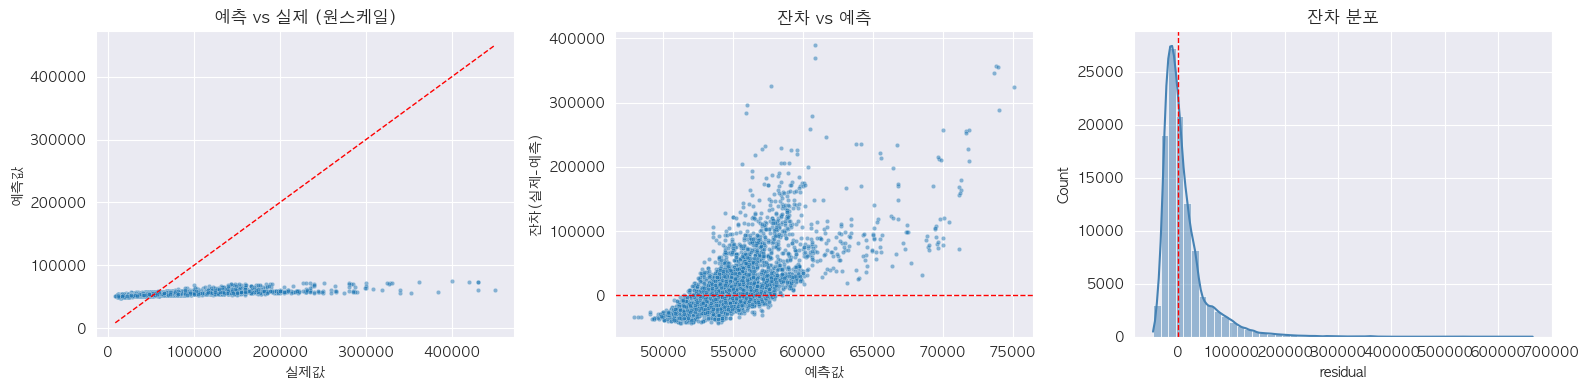

In [62]:
# 안전장치(음수 방지), 반올림 버전이 필요하면 아래 주석 해제
y_pred = np.maximum(0, y_pred)
# y_pred_int = y_pred.round().astype(np.int64)

# 지표 계산
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = np.mean(np.abs(y_true - y_pred))
r2 = r2_score(y_true, y_pred)

print(f"[Train In-sample] RMSE(orig) = {rmse:,.4f}")
print(f"[Train In-sample] MAE(orig)  = {mae:,.4f}")
print(f"[Train In-sample] R²         = {r2:,.4f}")

# 비교/잔차 프레임
compare_df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
})
compare_df['residual'] = compare_df['y_true'] - compare_df['y_pred']
display(compare_df.head(10))

# 필요 시 저장
# compare_df.to_csv('rf_train_vs_pred.csv', index=False)

# 시각화(샘플 5,000개까지)
sample = compare_df.sample(min(5000, len(compare_df)), random_state=2023)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1) 예측 vs 실제
sns.scatterplot(x='y_true', y='y_pred', data=sample, s=10, alpha=0.5, ax=axes[0])
lim_min = min(sample['y_true'].min(), sample['y_pred'].min())
lim_max = max(sample['y_true'].max(), sample['y_pred'].max())
axes[0].plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--', linewidth=1)
axes[0].set_title('예측 vs 실제 (원스케일)')
axes[0].set_xlabel('실제값')
axes[0].set_ylabel('예측값')

# 2) 잔차 vs 예측
sns.scatterplot(x='y_pred', y='residual', data=sample, s=10, alpha=0.5, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('잔차 vs 예측')
axes[1].set_xlabel('예측값')
axes[1].set_ylabel('잔차(실제-예측)')

# 3) 잔차 분포
sns.histplot(compare_df['residual'], bins=50, kde=True, ax=axes[2], color='steelblue')
axes[2].axvline(0, color='red', linestyle='--', linewidth=1)
axes[2].set_title('잔차 분포')

plt.tight_layout()
plt.show()

In [63]:
preds_test_log = best_pipe.predict(X_test)
preds_test = np.expm1(preds_test_log)
preds_test = np.maximum(0, preds_test)  # 음수 방지 안전장치
preds_test_int = preds_test.round().astype(np.int64)

In [64]:
# 저장
sub_path = 'rf_kfold_ohe_best.csv'
pd.DataFrame({'target': preds_test_int}).to_csv(sub_path, index=False)
print(f"[SAVE] {sub_path} 저장 완료")


[SAVE] rf_kfold_ohe_best.csv 저장 완료


In [65]:
# 파이프라인에서 전처리와 모델 추출
pre_fitted = best_pipe.named_steps['pre']
rf_fitted = best_pipe.named_steps['model']

In [66]:
# 확장된 피처 이름
feature_names = pre_fitted.get_feature_names_out()
importances = pd.Series(rf_fitted.feature_importances_, index=feature_names).sort_values(ascending=False)

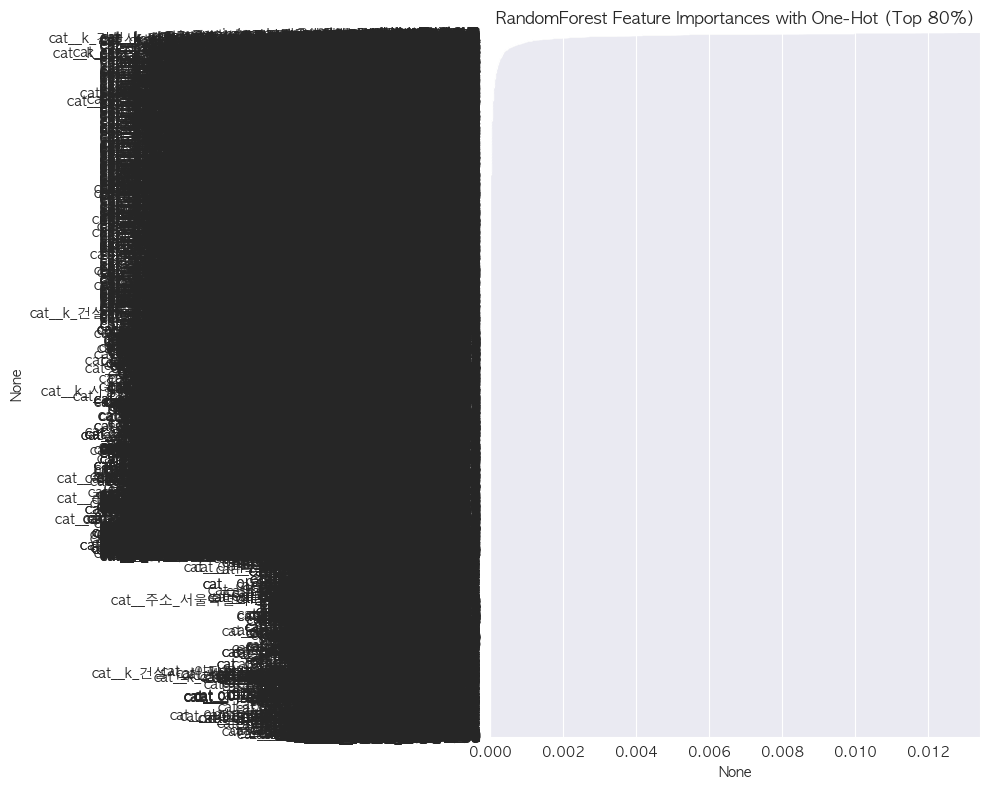

In [67]:
# 상위 80%만 시각화
top_n = max(1, int(np.ceil(len(importances) * 0.8)))
imp_top = importances.iloc[:top_n]

plt.figure(figsize=(10, 8))
plt.title("RandomForest Feature Importances with One-Hot (Top 80%)")
sns.barplot(x=imp_top, y=imp_top.index, color='steelblue')
plt.tight_layout()
plt.show()